### This file loads the proxy model trained with IIT, and evaluate it for concept-based explanations with the CEBaB dataset.
This file tends to follow the one in our OpenTable repo.

In [1]:
import json
import os 
import pandas as pd
import datasets
from collections import defaultdict
import numpy as np
import random
from tqdm import tqdm
import copy
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
from collections import Counter
import itertools

import torch
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer, 
    AutoConfig,
)
from math import ceil

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from models.modelings_roberta import *
from models.modelings_bert import *

from eval_pipeline.models.abstract_model import Model 
from eval_pipeline.explainers.abstract_explainer import Explainer
from eval_pipeline.utils.data_utils import preprocess_hf_dataset
from eval_pipeline.customized_models.bert import BertForNonlinearSequenceClassification
from eval_pipeline.utils import metric_utils, get_intervention_pairs
from eval_pipeline.explainers.random_explainer import RandomExplainer
from eval_pipeline.explainers.conexp import CONEXP
from scipy.spatial.distance import cosine

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
# TODO: set random seeds.
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

def query_with_aspect_label(
    df,
    ambiance="Positive",
    service="Positive",
    noise="Positive",
    food="Positive",
):
    return df[
        (df["ambiance_aspect_majority"]==ambiance)&
        (df["service_aspect_majority"]==service)&
        (df["noise_aspect_majority"]==noise)&
        (df["food_aspect_majority"]==food)
    ]

def flatten_logits(
    df,
    col_names,
):
    flatten_list = []
    for col_name in col_names:
        for row in df[col_name]:
            new_row = [v for v in row]
            new_row.append(col_name)
            flatten_list.append(new_row)
    col_names = [f"feature_{i}" for i in range(len(flatten_list[-1])-1)]
    col_names.append("type")
    df = pd.DataFrame(
        flatten_list, 
        columns=col_names
    )
    return df

In [3]:
class BERTForCEBaB(Model):
    def __init__(self, model_path, device='cpu', batch_size=64):
        self.device = device
        self.model_path = model_path
        self.tokenizer_path = model_path
        self.batch_size = batch_size

        self.model = BertForNonlinearSequenceClassification.from_pretrained(
            self.model_path,
            cache_dir="../huggingface_cache"
        )
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

        self.model.to(device)

    def __str__(self):
        return self.model_path.split('/')[-1]

    def preprocess(self, df):
        x = self.tokenizer(df['description'].to_list(), padding=True, truncation=True, return_tensors='pt')
        y = df['review_majority'].astype(int)

        return x, y

    def fit(self, dataset):
        # assume model was already trained
        pass

    def predict_proba(self, dataset):
        self.model.eval()

        x, y = self.preprocess(dataset)

        # get the predictions batch per batch
        probas = []
        for i in range(ceil(len(dataset) / self.batch_size)):
            x_batch = {k: v[i * self.batch_size:(i + 1) * self.batch_size].to(self.device) for k, v in x.items()}
            probas.append(torch.nn.functional.softmax(self.model(**x_batch).logits.cpu(), dim=-1).detach())

        probas = torch.concat(probas)
        probas = np.round(probas.numpy(), decimals=16)

        predictions = np.argmax(probas, axis=1)
        clf_report = classification_report(y.to_numpy(), predictions, output_dict=True)

        return probas, clf_report

    def get_embeddings(self, sentences_list):
        x = self.tokenizer(sentences_list, padding=True, truncation=True, return_tensors='pt')
        embeddings = []
        for i in range(ceil(len(x['input_ids']) / self.batch_size)):
            x_batch = {k: v[i * self.batch_size:(i + 1) * self.batch_size].to(self.device) for k, v in x.items()}
            embeddings.append(self.model.base_model(**x_batch).pooler_output.detach().cpu().tolist())

        return embeddings

    def get_classification_head(self):
        return self.model.classifier
    
def get_iit_examples(df):
    """
    Given a dataframe in the new data scheme, return all intervention pairs.
    """
    # Drop label distribution and worker information.
    columns_to_keep = ['id', 'original_id', 'edit_id', 'is_original', 'edit_goal', 'edit_type', 'description', 'review_majority','food_aspect_majority', 'ambiance_aspect_majority', 'service_aspect_majority', 'noise_aspect_majority']
    columns_to_keep += [col for col in df.columns if 'prediction' in col]
    df = df[columns_to_keep]
    return df

class CausalProxyModel(Explainer):
    def __init__(
        self, 
        blackbox_model_path,
        cpm_model_path, 
        device, batch_size, 
        intervention_h_dim=1,
        min_iit_pair_examples=1,
        match_non_int_type=False,
    ):
        self.batch_size = batch_size
        self.device = device
        self.min_iit_pair_examples = min_iit_pair_examples
        self.match_non_int_type = match_non_int_type
        # blackbox model loading.
        self.blackbox_model = BertForNonlinearSequenceClassification.from_pretrained(
            blackbox_model_path,
            cache_dir="../huggingface_cache"
        )
        self.blackbox_model.to(device)
        
        # causal proxy model loading.
        cpm_config = AutoConfig.from_pretrained(
            cpm_model_path,
            cache_dir="../huggingface_cache/",
            use_auth_token=True if "CEBaB/" in cpm_model_path else False,
        )
        try:
            cpm_config.intervention_h_dim = cpm_config.intervention_h_dim
        except:
            cpm_config.intervention_h_dim = intervention_h_dim
        print(f"intervention_h_dim={cpm_config.intervention_h_dim}")
        cpm_model = IITBERTForSequenceClassification.from_pretrained(
            cpm_model_path,
            config=cpm_config,
            cache_dir="../huggingface_cache/"
        )
        cpm_model.to(device)
        self.cpm_model = InterventionableIITTransformerForSequenceClassification(
            model=cpm_model
        )
        
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        
    def fit(self, dataset, classifier_predictions, classifier, dev_dataset=None):
        # we don't need to train IIT here.
        pass
    
    def preprocess(self, pairs_dataset, dev_dataset):
        
        # configs
        min_iit_pair_examples = self.min_iit_pair_examples
        match_non_int_type = self.match_non_int_type
        
        query_dataset = get_iit_examples(dev_dataset)
        iit_pairs_dataset = []
        iit_id = 0
        for index, row in pairs_dataset.iterrows():
            query_description_base = row['description_base']
            query_int_type = row['intervention_type']
            query_non_int_type = {
                "ambiance", "food", "noise", "service"
            } - {query_int_type}
            query_int_aspect_base = row["intervention_aspect_base"]
            query_int_aspect_assignment = row['intervention_aspect_counterfactual']
            query_original_id = row["original_id_base"]
            matched_iit_examples = query_dataset[
                (query_dataset[f"{query_int_type}_aspect_majority"]==query_int_aspect_assignment)&
                (query_dataset["original_id"]!=query_original_id)
            ]
            if match_non_int_type:
                for _t in query_non_int_type:
                    matched_iit_examples = matched_iit_examples[
                        (matched_iit_examples[f"{_t}_aspect_majority"]==\
                         row[f"{_t}_aspect_majority_base"])
                    ]
            if len(set(matched_iit_examples["id"])) < min_iit_pair_examples:
                if match_non_int_type:
                    # simply avoid mapping the rest of the aspects.
                    matched_iit_examples = query_dataset[
                        (query_dataset[f"{query_int_type}_aspect_majority"]==query_int_aspect_assignment)&
                        (query_dataset["original_id"]!=query_original_id)
                    ]
                else:
                    assert False # we need to check the number!
            sampled_iit_example_ids = random.sample(
                set(matched_iit_examples["id"]), min_iit_pair_examples
            )
            for _id in sampled_iit_example_ids:
                description_iit = query_dataset[query_dataset["id"]==_id]["description"].iloc[0]
                iit_pairs_dataset += [[
                    iit_id,
                    query_int_type,
                    query_description_base, 
                    description_iit
                ]]
            iit_id += 1
        iit_pairs_dataset = pd.DataFrame(
            columns=[
                'iit_id',
                'intervention_type', 
                'description_base', 
                'description_iit'], 
            data=iit_pairs_dataset
        )
        
        base_x = self.tokenizer(
            iit_pairs_dataset['description_base'].to_list(), 
            padding=True, truncation=True, return_tensors='pt'
        )
        source_x = self.tokenizer(
            iit_pairs_dataset['description_iit'].to_list(), 
            padding=True, truncation=True, return_tensors='pt'
        )
        intervention_corr = []
        for _type in iit_pairs_dataset["intervention_type"].tolist():
            if _type == "ambiance":
                intervention_corr += [0]
            if _type == "food":
                intervention_corr += [1]
            if _type == "noise":
                intervention_corr += [2]
            if _type == "service":
                intervention_corr += [3]
        intervention_corr = torch.tensor(intervention_corr).long()
        return base_x, source_x, intervention_corr, iit_pairs_dataset
    
    def estimate_icace(self, pairs, df):
        CPM_iTEs = []
        self.blackbox_model.eval()
        self.cpm_model.model.eval()
        base_x, source_x, intervention_corr, iit_pairs_dataset = self.preprocess(
            pairs, df
        )
        with torch.no_grad():
            for i in tqdm(range(ceil(len(iit_pairs_dataset)/self.batch_size))):
                base_x_batch = {k:v[i*self.batch_size:(i+1)*self.batch_size].to(self.device) for k,v in base_x.items()} 
                source_x_batch = {k:v[i*self.batch_size:(i+1)*self.batch_size].to(self.device) for k,v in source_x.items()} 
                intervention_corr_batch = intervention_corr[i*self.batch_size:(i+1)*self.batch_size].to(self.device)
                
                base_outputs = torch.nn.functional.softmax(
                    self.blackbox_model(**base_x_batch).logits.cpu(), dim=-1
                ).detach()
                _, _, counterfactual_outputs = self.cpm_model.forward(
                    base=(base_x_batch['input_ids'], base_x_batch['attention_mask']),
                    source=(source_x_batch['input_ids'], source_x_batch['attention_mask']),
                    base_intervention_corr=intervention_corr_batch,
                    source_intervention_corr=intervention_corr_batch,
                )
                counterfactual_outputs = torch.nn.functional.softmax(
                    counterfactual_outputs["logits"][0].cpu(), dim=-1
                ).detach()
                CPM_iTE = counterfactual_outputs-base_outputs
                CPM_iTEs.append(CPM_iTE)
        CPM_iTEs = torch.concat(CPM_iTEs)
        CPM_iTEs = np.round(CPM_iTEs.numpy(), decimals=4)

        # only for iit explainer!
        iit_pairs_dataset["EiCaCE"] = list(CPM_iTEs)
        CPM_iTEs = list(iit_pairs_dataset.groupby(["iit_id"])["EiCaCE"].mean())
        
        return CPM_iTEs


In [4]:
def cebab_pipeline(
    model, explainer, 
    train_dataset, dev_dataset, 
    dataset_type='5-way', 
    shorten_model_name=False,
    correction_epsilon=0.001,
):
    # get predictions on train and dev
    train_predictions, _ = model.predict_proba(
        train_dataset
    )
    dev_predictions, dev_report = model.predict_proba(
        dev_dataset
    )

    # append predictions to datasets
    train_dataset['prediction'] = list(train_predictions)
    dev_dataset['prediction'] = list(dev_predictions)

    # fit explainer
    explainer.fit(
        train_dataset, train_predictions, 
        model, dev_dataset
    )

    # get intervention pairs
    
    pairs_dataset = get_intervention_pairs(
        dev_dataset, dataset_type=dataset_type
    )  # TODO why is the index not unique here?
        
    # get explanations
    if isinstance(explanator, CausalProxyModel):
        explanations = explainer.estimate_icace(
            pairs_dataset,
            train_dataset # for query data.
        )
    else:
        explanations = explainer.estimate_icace(
            pairs_dataset,
        )
    
    # append explanations to the pairs
    pairs_dataset['EICaCE'] = explanations
    
    # TODO: add cosine
    pairs_dataset = metric_utils._calculate_ite(pairs_dataset)  # effect of crowd-workers on other crowd-workers (no model, no explainer)
    
    def _calculate_icace(pairs):
        """
        This metric measures the effect of a certain concept on the given model.
        It is independent of the explainer.
        """
        pairs['ICaCE'] = (pairs['prediction_counterfactual'] - pairs['prediction_base']).apply(lambda x: np.round(x, decimals=4))

        return pairs
    pairs_dataset = _calculate_icace(pairs_dataset)  # effect of concept on the model (with model, no explainer)
    
    # TOREMOVE: just to try if we ignore all [0,0,...] cases here.
    # zeros_like = tuple([0.0 for i in range(int(dataset_type.split("-")[0]))])
    # pairs_dataset = pairs_dataset[pairs_dataset.ICaCE.map(tuple).isin([zeros_like])==False]
    
    def _cosine_distance(a,b,epsilon):
        if epsilon == None:
            if np.linalg.norm(a, ord=2) == 0 or np.linalg.norm(b, ord=2) == 0:
                return 1
            else:
                return cosine(a,b)
        
        if np.linalg.norm(a, ord=2) == 0 and np.linalg.norm(b, ord=2) == 0:
            """
            We cannot determine whether prediction is corrected or not.
            Thus, we simply return 1.
            """
            return 1
        elif np.linalg.norm(a, ord=2) == 0:
            """
            When true iCACE score is 0, instead of always returning 1, we
            allow some epsilon error by default. If the EiCACE is within a
            range, we return the error as 0.
            """
            if np.max(np.abs(b)) <= epsilon:
                return 0
            else:
                return 1
        elif np.linalg.norm(b, ord=2) == 0:
            """
            This case happens when iCACE is not 0, but EiCACE is 0. This is
            unlikely, but we give score of 1 for this case.
            """
            return 1
        else:
            return cosine(a,b)
    
    def _calculate_estimate_loss(pairs,epsilon):
        """
        Calculate the distance between the ICaCE and EICaCE.
        """

        pairs['ICaCE-L2'] = pairs[['ICaCE', 'EICaCE']].apply(lambda x: np.linalg.norm(x[0] - x[1], ord=2), axis=1)
        pairs['ICaCE-cosine'] = pairs[['ICaCE', 'EICaCE']].apply(lambda x: _cosine_distance(x[0], x[1], epsilon), axis=1)
        pairs['ICaCE-normdiff'] = pairs[['ICaCE', 'EICaCE']].apply(lambda x: abs(np.linalg.norm(x[0], ord=2) - np.linalg.norm(x[1], ord=2)), axis=1)

        return pairs
    
    pairs_dataset = _calculate_estimate_loss(pairs_dataset,correction_epsilon)  # l2 CEBaB Score (model and explainer)

    # only keep columns relevant for metrics
    CEBaB_metrics_per_pair = pairs_dataset[[
        'intervention_type', 'intervention_aspect_base', 'intervention_aspect_counterfactual', 'ITE', 'ICaCE', 'EICaCE', 'ICaCE-L2', 'ICaCE-cosine', 'ICaCE-normdiff']].copy()
    CEBaB_metrics_per_pair['count'] = 1

    # get CEBaB tables
    metrics = ['count', 'ICaCE', 'EICaCE']

    groupby_aspect_direction = ['intervention_type', 'intervention_aspect_base', 'intervention_aspect_counterfactual']

    CaCE_per_aspect_direction = metric_utils._aggregate_metrics(CEBaB_metrics_per_pair, groupby_aspect_direction, metrics)
    CaCE_per_aspect_direction.columns = ['count', 'CaCE', 'ECaCE']
    CaCE_per_aspect_direction = CaCE_per_aspect_direction.set_index(['count'], append=True)
    
    ACaCE_per_aspect = metric_utils._aggregate_metrics(CaCE_per_aspect_direction.abs(), ['intervention_type'], ['CaCE', 'ECaCE'])
    ACaCE_per_aspect.columns = ['ACaCE', 'EACaCE']

    CEBaB_metrics_per_aspect_direction = metric_utils._aggregate_metrics(CEBaB_metrics_per_pair, groupby_aspect_direction, ['count', 'ICaCE-L2', 'ICaCE-cosine', 'ICaCE-normdiff'])
    CEBaB_metrics_per_aspect_direction.columns = ['count', 'ICaCE-L2', 'ICaCE-cosine', 'ICaCE-normdiff']
    CEBaB_metrics_per_aspect_direction = CEBaB_metrics_per_aspect_direction.set_index(['count'], append=True)

    CEBaB_metrics_per_aspect = metric_utils._aggregate_metrics(CEBaB_metrics_per_pair, ['intervention_type'], ['count', 'ICaCE-L2', 'ICaCE-cosine', 'ICaCE-normdiff'])
    CEBaB_metrics_per_aspect.columns = ['count', 'ICaCE-L2', 'ICaCE-cosine', 'ICaCE-normdiff']
    CEBaB_metrics_per_aspect = CEBaB_metrics_per_aspect.set_index(['count'], append=True)

    CEBaB_metrics = metric_utils._aggregate_metrics(CEBaB_metrics_per_pair, [], ['ICaCE-L2', 'ICaCE-cosine', 'ICaCE-normdiff'])

    # get ATE table
    ATE = metric_utils._aggregate_metrics(CEBaB_metrics_per_pair, groupby_aspect_direction, ['count', 'ITE'])
    ATE.columns = ['count', 'ATE']

    # add model and explainer information
    if shorten_model_name:
        model_name = str(model).split('.')[0]
    else:
        model_name = str(model)

    CaCE_per_aspect_direction.columns = pd.MultiIndex.from_tuples(
        [(model_name, str(explainer), col) if col != 'CaCE' else (model_name, '', col) for col in CaCE_per_aspect_direction.columns])
    ACaCE_per_aspect.columns = pd.MultiIndex.from_tuples(
        [(model_name, str(explainer), col) if col != 'ACaCE' else (model_name, '', col) for col in ACaCE_per_aspect.columns])
    CEBaB_metrics_per_aspect_direction.columns = pd.MultiIndex.from_tuples(
        [(model_name, str(explainer), col) for col in CEBaB_metrics_per_aspect_direction.columns])
    CEBaB_metrics_per_aspect.columns = pd.MultiIndex.from_tuples(
        [(model_name, str(explainer), col) for col in CEBaB_metrics_per_aspect.columns])
    CEBaB_metrics.index = pd.MultiIndex.from_product([[model_name], [str(explainer)], CEBaB_metrics.index])
    
    # performance report
    performance_report_index = ['macro-f1', 'accuracy']
    performance_report_data = [dev_report['macro avg']['f1-score'], dev_report['accuracy']]
    performance_report_col = [model_name]
    performance_report = pd.DataFrame(data=performance_report_data, index=performance_report_index, columns=performance_report_col)

    return pairs_dataset, ATE, CEBaB_metrics, CEBaB_metrics_per_aspect_direction, CEBaB_metrics_per_aspect, CaCE_per_aspect_direction, ACaCE_per_aspect, performance_report

Mannual Evaluation

In [193]:
grid = {
    "h_dim": [1],
    "class_num": [2, 3, 5],
    "control": [False, True],
    "beta" : [1.0],
    "gemma" : [3.0],
    "cls_dropout" : [0.0],
    "enc_dropout" : [0.0],
}

keys, values = zip(*grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [194]:
results = {}
for i in range(len(permutations_dicts)):
    
    seed=42
    class_num=permutations_dicts[i]["class_num"]
    beta=permutations_dicts[i]["beta"]
    gemma=permutations_dicts[i]["gemma"]
    h_dim=permutations_dicts[i]["h_dim"]
    dataset_type = f'{class_num}-way'
    correction_epsilon=None
    cls_dropout=0.1
    enc_dropout=0.1
    control=permutations_dicts[i]["control"]
    
    grid_conditions=(
        ("seed", seed),
        ("class_num", class_num),
        ("beta", beta),
        ("gemma", gemma),
        ("h_dim", h_dim),
        ("dataset_type", dataset_type),
        ("correction_epsilon", correction_epsilon),
        ("cls_dropout", cls_dropout),
        ("enc_dropout", enc_dropout),
        ("control", control),
    )
    print("Running for this setting: ", grid_conditions)

    blackbox_model_path = f'CEBaB/bert-base-uncased.CEBaB.sa.{class_num}-class.exclusive.seed_{seed}'
    if control:
        cpm_model_path = blackbox_model_path
    else:
        cpm_model_path = f'./proxy_training_results/'\
                           f'cebab.train.train.alpha.1.0'\
                           f'.beta.{beta}.gemma.{gemma}.dim.{h_dim}.hightype.'\
                           f'bert-base-uncased.Proxy.'\
                           f'CEBaB.sa.{class_num}-class.exclusive.'\
                           f'mode.align.cls.dropout.{cls_dropout}.enc.dropout.{enc_dropout}.seed_{seed}'

    device = 'cuda:8'
    batch_size = 32

    # load data from HF
    cebab = datasets.load_dataset(
        'CEBaB/CEBaB', use_auth_token=True,
        cache_dir="../huggingface_cache/"
    )
    cebab['train'] = cebab['train_exclusive']
    train, dev, test = preprocess_hf_dataset(
        cebab, one_example_per_world=False, 
        verbose=1, dataset_type=dataset_type
    )

    tf_model = BERTForCEBaB(
        blackbox_model_path, 
        device=device, 
        batch_size=batch_size
    )
    explanator = CausalProxyModel(
        blackbox_model_path,
        cpm_model_path, 
        device=device, 
        batch_size=batch_size,
        intervention_h_dim=h_dim,
    )

    train_dataset = train.copy()
    dev_dataset = test.copy()

    result_per_example, ATE, CEBaB_metrics, CEBaB_metrics_per_aspect_direction, \
    CEBaB_metrics_per_aspect, CaCE_per_aspect_direction, \
    ACaCE_per_aspect, performance_report = cebab_pipeline(
        tf_model, explanator, 
        train_dataset, dev_dataset, 
        dataset_type=dataset_type,
        correction_epsilon=correction_epsilon,
    )
    
    results[grid_conditions] = (
        result_per_example, ATE, CEBaB_metrics, CEBaB_metrics_per_aspect_direction, \
        CEBaB_metrics_per_aspect, CaCE_per_aspect_direction, \
        ACaCE_per_aspect, performance_report
    )

Running for this setting:  (('seed', 42), ('class_num', 2), ('beta', 1.0), ('gemma', 3.0), ('h_dim', 1), ('dataset_type', '2-way'), ('correction_epsilon', None), ('cls_dropout', 0.1), ('enc_dropout', 0.1), ('control', False))


Using custom data configuration CEBaB--CEBaB-0e2f7ed67c9d7e55
Reusing dataset parquet (../huggingface_cache/parquet/CEBaB--CEBaB-0e2f7ed67c9d7e55/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/4 [00:00<?, ?it/s]

Dropping no majority reviews: 16.03% of train dataset.
Dropped 2604 examples with a neutral label.
Dropped 452 examples with a neutral label.
Dropped 461 examples with a neutral label.


/dfs/user/wuzhengx/workspace/causal-proxy-model/eval_pipeline/utils/data_utils.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['review_majority'] = dataset['review_majority'].apply(lambda score: encoding[score])


intervention_h_dim=1


100%|██████████| 72/72 [00:13<00:00,  5.20it/s]


Running for this setting:  (('seed', 42), ('class_num', 2), ('beta', 1.0), ('gemma', 3.0), ('h_dim', 1), ('dataset_type', '2-way'), ('correction_epsilon', None), ('cls_dropout', 0.1), ('enc_dropout', 0.1), ('control', True))


Using custom data configuration CEBaB--CEBaB-0e2f7ed67c9d7e55
Reusing dataset parquet (../huggingface_cache/parquet/CEBaB--CEBaB-0e2f7ed67c9d7e55/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/4 [00:00<?, ?it/s]

Dropping no majority reviews: 16.03% of train dataset.
Dropped 2604 examples with a neutral label.
Dropped 452 examples with a neutral label.
Dropped 461 examples with a neutral label.
intervention_h_dim=1


Some weights of IITBERTForSequenceClassification were not initialized from the model checkpoint at CEBaB/bert-base-uncased.CEBaB.sa.2-class.exclusive.seed_42 and are newly initialized: ['multitask_classifier.dense.bias', 'multitask_classifier.out_proj.bias', 'multitask_classifier.dense.weight', 'multitask_classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 72/72 [00:15<00:00,  4.77it/s]


Running for this setting:  (('seed', 42), ('class_num', 3), ('beta', 1.0), ('gemma', 3.0), ('h_dim', 1), ('dataset_type', '3-way'), ('correction_epsilon', None), ('cls_dropout', 0.1), ('enc_dropout', 0.1), ('control', False))


Using custom data configuration CEBaB--CEBaB-0e2f7ed67c9d7e55
Reusing dataset parquet (../huggingface_cache/parquet/CEBaB--CEBaB-0e2f7ed67c9d7e55/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/4 [00:00<?, ?it/s]

Dropping no majority reviews: 16.03% of train dataset.
intervention_h_dim=1


100%|██████████| 124/124 [00:26<00:00,  4.71it/s]


Running for this setting:  (('seed', 42), ('class_num', 3), ('beta', 1.0), ('gemma', 3.0), ('h_dim', 1), ('dataset_type', '3-way'), ('correction_epsilon', None), ('cls_dropout', 0.1), ('enc_dropout', 0.1), ('control', True))


Using custom data configuration CEBaB--CEBaB-0e2f7ed67c9d7e55
Reusing dataset parquet (../huggingface_cache/parquet/CEBaB--CEBaB-0e2f7ed67c9d7e55/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/4 [00:00<?, ?it/s]

Dropping no majority reviews: 16.03% of train dataset.
intervention_h_dim=1


Some weights of IITBERTForSequenceClassification were not initialized from the model checkpoint at CEBaB/bert-base-uncased.CEBaB.sa.3-class.exclusive.seed_42 and are newly initialized: ['multitask_classifier.dense.bias', 'multitask_classifier.out_proj.bias', 'multitask_classifier.dense.weight', 'multitask_classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 124/124 [00:24<00:00,  5.01it/s]


Running for this setting:  (('seed', 42), ('class_num', 5), ('beta', 1.0), ('gemma', 3.0), ('h_dim', 1), ('dataset_type', '5-way'), ('correction_epsilon', None), ('cls_dropout', 0.1), ('enc_dropout', 0.1), ('control', False))


Using custom data configuration CEBaB--CEBaB-0e2f7ed67c9d7e55
Reusing dataset parquet (../huggingface_cache/parquet/CEBaB--CEBaB-0e2f7ed67c9d7e55/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/4 [00:00<?, ?it/s]

Dropping no majority reviews: 16.03% of train dataset.
intervention_h_dim=1


100%|██████████| 124/124 [00:26<00:00,  4.69it/s]


Running for this setting:  (('seed', 42), ('class_num', 5), ('beta', 1.0), ('gemma', 3.0), ('h_dim', 1), ('dataset_type', '5-way'), ('correction_epsilon', None), ('cls_dropout', 0.1), ('enc_dropout', 0.1), ('control', True))


Using custom data configuration CEBaB--CEBaB-0e2f7ed67c9d7e55
Reusing dataset parquet (../huggingface_cache/parquet/CEBaB--CEBaB-0e2f7ed67c9d7e55/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/4 [00:00<?, ?it/s]

Dropping no majority reviews: 16.03% of train dataset.
intervention_h_dim=1


Some weights of IITBERTForSequenceClassification were not initialized from the model checkpoint at CEBaB/bert-base-uncased.CEBaB.sa.5-class.exclusive.seed_42 and are newly initialized: ['multitask_classifier.dense.bias', 'multitask_classifier.out_proj.bias', 'multitask_classifier.dense.weight', 'multitask_classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 124/124 [00:25<00:00,  4.88it/s]


In [195]:
important_keys = list(grid.keys())
values = []
for k, v in results.items():
    _values = []
    for ik in important_keys:
        _values.append(dict(k)[ik])
    _values.append(v[2]["ICaCE-L2"].iloc[0])
    _values.append(v[2]["ICaCE-cosine"].iloc[0])
    _values.append(v[2]["ICaCE-normdiff"].iloc[0])
    _values.append(v[-1].iloc[0][0])
    values.append(_values)
important_keys.extend(["ICaCE-L2", "ICaCE-cosine", "ICaCE-normdiff", "macro-f1"])
df = pd.DataFrame(values, columns=important_keys)
df.sort_values(by=['class_num'], ascending=True)

h_dim  class_num  control  beta  gemma  cls_dropout  enc_dropout  ICaCE-L2  \
0      1          2    False   1.0    3.0          0.1          0.1    0.2304   
1      1          2     True   1.0    3.0          0.1          0.1    0.2895   
2      1          3    False   1.0    3.0          0.1          0.1    0.4689   
3      1          3     True   1.0    3.0          0.1          0.1    0.5516   
4      1          5    False   1.0    3.0          0.1          0.1    0.7220   
5      1          5     True   1.0    3.0          0.1          0.1    0.8136   

   ICaCE-cosine  ICaCE-normdiff  macro-f1  
0        0.7916          0.2285  0.976104  
1        1.0044          0.2894  0.976104  
2        0.6467          0.3964  0.812163  
3        0.9855          0.5511  0.812163  
4        0.5040          0.5456  0.696461  
5        0.9641          0.8125  0.696461

Static Pool Evaluation

In [5]:
class StaticCausalProxyModel(Explainer):
    def __init__(
        self, 
        blackbox_model_path,
        cpm_model_path, 
        device, batch_size, 
        intervention_h_dim=1,
        min_iit_pair_examples=1,
        match_non_int_type=False,
    ):
        self.batch_size = batch_size
        self.device = device
        self.min_iit_pair_examples = min_iit_pair_examples
        self.match_non_int_type = match_non_int_type
        self.intervention_h_dim = intervention_h_dim
        # blackbox model loading.
        self.blackbox_model = BertForNonlinearSequenceClassification.from_pretrained(
            blackbox_model_path,
            cache_dir="../huggingface_cache"
        )
        self.blackbox_model.to(device)
        
        # causal proxy model loading.
        cpm_config = AutoConfig.from_pretrained(
            cpm_model_path,
            cache_dir="../huggingface_cache/",
            use_auth_token=True if "CEBaB/" in cpm_model_path else False,
        )
        try:
            cpm_config.intervention_h_dim = cpm_config.intervention_h_dim
        except:
            cpm_config.intervention_h_dim = intervention_h_dim
        print(f"intervention_h_dim={cpm_config.intervention_h_dim}")
        cpm_model = IITBERTForSequenceClassification.from_pretrained(
            cpm_model_path,
            config=cpm_config,
            cache_dir="../huggingface_cache/"
        )
        cpm_model.to(device)
        self.cpm_model = InterventionableIITTransformerForSequenceClassification(
            model=cpm_model
        )
        
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        
        self.clean()
        
    def clean(self):
        self.hidden_repr_static_pool = {}
        for concept in ["ambiance", "food", "noise", "service"]:
            for concept_label in ["Positive", "Negative", "unknown"]:
                self.hidden_repr_static_pool[(concept, concept_label)] = []
        
    def fit(self, 
            dataset, classifier_predictions, 
            classifier, dev_dataset=None,
            reduce=True, control=False,
           ):
        """
        For static CPM model, we need to extract the hidden representations for
        concepts before estimating iCACE scores.
        """
        self.blackbox_model.eval()
        self.cpm_model.model.eval()

        x, y, ambiance_label, food_label, noise_label, service_labal = self.preprocess(dataset)

        # get the predictions batch per batch
        cls_hidden_states = []
        for i in range(ceil(len(dataset) / self.batch_size)):
            x_batch = {k: v[i * self.batch_size:(i + 1) * self.batch_size].to(self.device) for k, v in x.items()}
            if control:
                cls_hidden_state = self.blackbox_model(
                    **x_batch,
                    output_hidden_states=True,
                ).hidden_states[-1][:,0,:].cpu().detach()
            else:
                cls_hidden_state = self.cpm_model.model(
                    **x_batch,
                    output_hidden_states=True,
                ).hidden_states[-1][:,0,:].cpu().detach()
            cls_hidden_states.append(cls_hidden_state)

        cls_hidden_states = torch.concat(cls_hidden_states)
        
        for i in range(0, len(ambiance_label)): 
            if ("ambiance", ambiance_label.iloc[i]) in self.hidden_repr_static_pool:
                start_idx = 0*self.intervention_h_dim
                end_idx = 1*self.intervention_h_dim
                self.hidden_repr_static_pool[("ambiance", ambiance_label.iloc[i])].append(
                    cls_hidden_states[i][start_idx:end_idx]
                )
            
            if ("food", food_label.iloc[i]) in self.hidden_repr_static_pool:
                start_idx = 1*self.intervention_h_dim
                end_idx = 2*self.intervention_h_dim
                self.hidden_repr_static_pool[("food", food_label.iloc[i])].append(
                    cls_hidden_states[i][start_idx:end_idx]
                )
                
            if ("noise", noise_label.iloc[i]) in self.hidden_repr_static_pool:
                start_idx = 2*self.intervention_h_dim
                end_idx = 3*self.intervention_h_dim
                self.hidden_repr_static_pool[("noise", noise_label.iloc[i])].append(
                    cls_hidden_states[i][start_idx:end_idx]
                )
                
            if ("service", service_labal.iloc[i]) in self.hidden_repr_static_pool:
                start_idx = 3*self.intervention_h_dim
                end_idx = 4*self.intervention_h_dim
                self.hidden_repr_static_pool[("service", service_labal.iloc[i])].append(
                    cls_hidden_states[i][start_idx:end_idx]
                )

        if reduce:
            for k, v in self.hidden_repr_static_pool.items():
                self.hidden_repr_static_pool[k] = torch.stack(v, dim=0).mean(dim=0)
        else:
            for k, v in self.hidden_repr_static_pool.items():
                self.hidden_repr_static_pool[k] = torch.stack(v, dim=0)
            
    def preprocess(self, df):
        x = self.tokenizer(df['description'].to_list(), padding=True, truncation=True, return_tensors='pt')
        y = df['review_majority'].astype(int)

        all_type = {
            "ambiance", "food", "noise", "service"
        }
        return x, y, \
            df['ambiance_aspect_majority'], \
            df['food_aspect_majority'], \
            df['noise_aspect_majority'], \
            df['service_aspect_majority']
    
    def preprocess_icace(self, pairs_dataset):
        
        # configs
        iit_pairs_dataset = []
        iit_id = 0
        for index, row in pairs_dataset.iterrows():
            query_description_base = row['description_base']
            query_int_type = row['intervention_type']
            query_int_aspect_base = row["intervention_aspect_base"]
            query_int_aspect_assignment = row['intervention_aspect_counterfactual']
            query_original_id = row["original_id_base"]
            iit_pairs_dataset += [[
                iit_id,
                query_int_type,
                query_description_base, 
                query_int_aspect_base,
                query_int_aspect_assignment
            ]]
            iit_id += 1
        iit_pairs_dataset = pd.DataFrame(
            columns=[
                'iit_id',
                'intervention_type', 
                'description_base', 
                'intervention_aspect_base',
                'intervention_aspect_counterfactual'], 
            data=iit_pairs_dataset
        )
        
        base_x = self.tokenizer(
            iit_pairs_dataset['description_base'].to_list(), 
            padding=True, truncation=True, return_tensors='pt'
        )

        intervention_corr = []
        source_x = []
        for i in range(len(iit_pairs_dataset["intervention_type"])):
            _type = iit_pairs_dataset["intervention_type"].iloc[i]
            _base_label = iit_pairs_dataset["intervention_aspect_base"].iloc[i]
            _label = iit_pairs_dataset["intervention_aspect_counterfactual"].iloc[i]
            if _type == "ambiance":
                intervention_corr += [0]
            if _type == "food":
                intervention_corr += [1]
            if _type == "noise":
                intervention_corr += [2]
            if _type == "service":
                intervention_corr += [3]
                
            """
            UNCOMMENT TO TRY:
            
            Just to try out if we actually care about the difference.
            This will need some modifications on the modeling files as well
            to consume this as a delta, not activation replacement.
            """
            # source_x += [
            #     self.hidden_repr_static_pool[(_type, _label)] - \
            #         self.hidden_repr_static_pool[(_type, _base_label)]
            # ]
            
            source_x += [
                self.hidden_repr_static_pool[(_type, _label)]
            ]
            
        source_x = torch.stack(source_x, dim=0)
        intervention_corr = torch.tensor(intervention_corr).long()
        return base_x, source_x, intervention_corr, iit_pairs_dataset
    
    def estimate_icace(self, pairs):
        
        CPM_iTEs = []
        self.blackbox_model.eval()
        self.cpm_model.model.eval()
        base_x, source_x, intervention_corr, iit_pairs_dataset = self.preprocess_icace(
            pairs,
        )
        with torch.no_grad():
            for i in tqdm(range(ceil(len(iit_pairs_dataset)/self.batch_size))):
                base_x_batch = {k:v[i*self.batch_size:(i+1)*self.batch_size].to(self.device) for k,v in base_x.items()} 
                source_x_batch = source_x[i*self.batch_size:(i+1)*self.batch_size].to(self.device)
                intervention_corr_batch = intervention_corr[i*self.batch_size:(i+1)*self.batch_size].to(self.device)
                
                base_outputs = torch.nn.functional.softmax(
                    self.blackbox_model(**base_x_batch).logits.cpu(), dim=-1
                ).detach()
                _, _, counterfactual_outputs = self.cpm_model.forward_with_hook(
                    base=(base_x_batch['input_ids'], base_x_batch['attention_mask']),
                    source_hidden_reprs=source_x_batch,
                    base_intervention_corr=intervention_corr_batch,
                    source_intervention_corr=intervention_corr_batch,
                )
                counterfactual_outputs = torch.nn.functional.softmax(
                    counterfactual_outputs["logits"][0].cpu(), dim=-1
                ).detach()
                CPM_iTE = counterfactual_outputs-base_outputs
                CPM_iTEs.append(CPM_iTE)
        CPM_iTEs = torch.concat(CPM_iTEs)
        CPM_iTEs = np.round(CPM_iTEs.numpy(), decimals=4)

        # only for iit explainer!
        iit_pairs_dataset["EiCaCE"] = list(CPM_iTEs)
        CPM_iTEs = list(iit_pairs_dataset.groupby(["iit_id"])["EiCaCE"].mean())
        
        return CPM_iTEs
    

In [6]:
grid = {
    "class_num": [2, 3, 5],
    "control": [False, True]  
}
keys, values = zip(*grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [7]:
permutations_dicts = permutations_dicts[-2:-1]
permutations_dicts

[{'class_num': 5, 'control': False}]

In [9]:
torch.cuda.empty_cache()

In [10]:
results = {}
for i in range(len(permutations_dicts)):
    
    seed=42
    class_num=permutations_dicts[i]["class_num"]
    beta=1.0
    gemma=3.0
    h_dim=192
    dataset_type = f'{class_num}-way'
    correction_epsilon=None
    cls_dropout=0.1
    enc_dropout=0.1
    control=permutations_dicts[i]["control"]
    
    grid_conditions=(
        ("seed", seed),
        ("class_num", class_num),
        ("beta", beta),
        ("gemma", gemma),
        ("h_dim", h_dim),
        ("dataset_type", dataset_type),
        ("correction_epsilon", correction_epsilon),
        ("cls_dropout", cls_dropout),
        ("enc_dropout", enc_dropout),
        ("control", control)
    )

    blackbox_model_path = f'CEBaB/bert-base-uncased.CEBaB.sa.{class_num}-class.exclusive.seed_{seed}'
    if control:
        cpm_model_path = blackbox_model_path
    else:
        cpm_model_path = f'./proxy_training_results/'\
                           f'cebab.train.train.alpha.1.0'\
                           f'.beta.{beta}.gemma.{gemma}.dim.{h_dim}.hightype.'\
                           f'bert-base-uncased.Proxy.'\
                           f'CEBaB.sa.{class_num}-class.exclusive.'\
                           f'mode.align.cls.dropout.{cls_dropout}.enc.dropout.{enc_dropout}.seed_{seed}'

    device = 0
    batch_size = 32

    # load data from HF
    cebab = datasets.load_dataset(
        'CEBaB/CEBaB', use_auth_token=True,
        cache_dir="../huggingface_cache/"
    )
    cebab['train'] = cebab['train_exclusive']
    train, dev, test = preprocess_hf_dataset(
        cebab, one_example_per_world=False, 
        verbose=1, dataset_type=dataset_type
    )

    tf_model = BERTForCEBaB(
        blackbox_model_path, 
        device=device, 
        batch_size=batch_size
    )
    explanator = StaticCausalProxyModel(
        blackbox_model_path,
        cpm_model_path, 
        device=device, 
        batch_size=batch_size,
        intervention_h_dim=h_dim,
    )

    train_dataset = train.copy()
    dev_dataset = test.copy()

    # result_per_example, ATE, CEBaB_metrics, CEBaB_metrics_per_aspect_direction, \
    # CEBaB_metrics_per_aspect, CaCE_per_aspect_direction, \
    # ACaCE_per_aspect, performance_report = cebab_pipeline(
    #     tf_model, explanator, 
    #     train_dataset, dev_dataset, 
    #     dataset_type=dataset_type,
    #     correction_epsilon=correction_epsilon,
    # )
    
    # results[grid_conditions] = (
    #     result_per_example, ATE, CEBaB_metrics, CEBaB_metrics_per_aspect_direction, \
    #     CEBaB_metrics_per_aspect, CaCE_per_aspect_direction, \
    #     ACaCE_per_aspect, performance_report
    # )

Using custom data configuration CEBaB--CEBaB-65fc31a444dff443
Reusing dataset parquet (../huggingface_cache/CEBaB___parquet\CEBaB--CEBaB-65fc31a444dff443\0.0.0\0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/4 [00:00<?, ?it/s]

Dropping no majority reviews: 16.03% of train dataset.
intervention_h_dim=192


iCACE evaluation with static pool CPM

t-SNE with CPM trained hidden representations

In [36]:
explanator.clean()
explanator.fit(
    train_dataset, 
    None, None, None,
    reduce=False, control=False,
)

cluster_labels = []
cluster_hidden_reprs = []
example_limit = 600
for concept in ["ambiance", "food", "noise", "service"]:
    for concept_label in ["Positive", "Negative", ]:
        hidden_repr_static_pool = explanator.hidden_repr_static_pool[(concept, concept_label)]
        hidden_repr_static_pool = hidden_repr_static_pool[torch.randperm(hidden_repr_static_pool.size()[0])]
        hidden_repr = hidden_repr_static_pool[:example_limit]
        cluster_labels.extend([f"{concept}-{concept_label}" for _ in range(hidden_repr.shape[0])])
        cluster_hidden_reprs += [hidden_repr]
cluster_hidden_reprs = torch.concat(cluster_hidden_reprs, dim=0)
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(cluster_hidden_reprs)
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = cluster_labels

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4800 samples in 0.126s...
[t-SNE] Computed neighbors for 4800 samples in 7.494s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4800
[t-SNE] Computed conditional probabilities for sample 2000 / 4800
[t-SNE] Computed conditional probabilities for sample 3000 / 4800
[t-SNE] Computed conditional probabilities for sample 4000 / 4800
[t-SNE] Computed conditional probabilities for sample 4800 / 4800
[t-SNE] Mean sigma: 2.184281
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.674477
[t-SNE] KL divergence after 1000 iterations: 0.784106


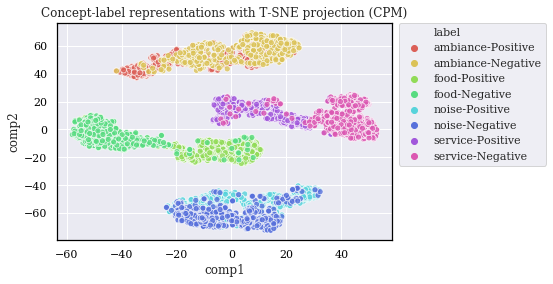

In [37]:
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 12}
plt.rc('font', **font)

with plt.rc_context({
    'axes.edgecolor':'black', 'xtick.color':'black', 
    'ytick.color':'black', 'figure.facecolor':'white'
}):
    sns.scatterplot(
        x="comp1", y="comp2", hue="label",
        palette=sns.color_palette("hls", 8),
        data=df_tsne, alpha=0.8
    ).set(title="Concept-label representations with T-SNE projection (CPM)")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [38]:
explanator.clean()
explanator.fit(
    train_dataset, 
    None, None, None,
    reduce=False, control=True,
)

cluster_labels = []
cluster_hidden_reprs = []
example_limit = 600
for concept in ["ambiance", "food", "noise", "service"]:
    for concept_label in ["Positive", "Negative", ]:
        hidden_repr = explanator.hidden_repr_static_pool[(concept, concept_label)][:example_limit]
        cluster_labels.extend([f"{concept}-{concept_label}" for _ in range(hidden_repr.shape[0])])
        cluster_hidden_reprs += [hidden_repr]
cluster_hidden_reprs = torch.concat(cluster_hidden_reprs, dim=0)
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(cluster_hidden_reprs)
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = cluster_labels

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4800 samples in 0.084s...
[t-SNE] Computed neighbors for 4800 samples in 5.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4800
[t-SNE] Computed conditional probabilities for sample 2000 / 4800
[t-SNE] Computed conditional probabilities for sample 3000 / 4800
[t-SNE] Computed conditional probabilities for sample 4000 / 4800
[t-SNE] Computed conditional probabilities for sample 4800 / 4800
[t-SNE] Mean sigma: 1.422322
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.260609
[t-SNE] KL divergence after 1000 iterations: 0.676615


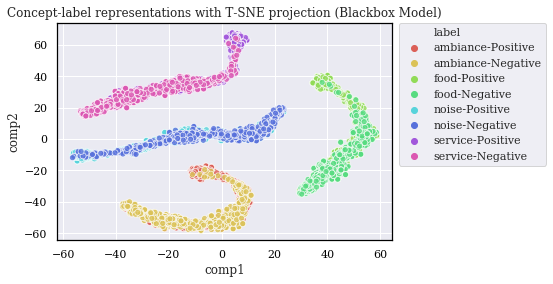

In [39]:
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 12}
plt.rc('font', **font)

with plt.rc_context({
    'axes.edgecolor':'black', 'xtick.color':'black', 
    'ytick.color':'black', 'figure.facecolor':'white'
}):
    sns.scatterplot(
        x="comp1", y="comp2", hue="label",
        palette=sns.color_palette("hls", 8),
        data=df_tsne, alpha=0.8
    ).set(title="Concept-label representations with T-SNE projection (Blackbox Model)")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

An LM debugging interface with CPM

In [11]:
def process_output(
    outputs,
    sequence_label_map={
        4 : "Very Positive",
        3 : "Positive",
        2 : "Neutral", 
        1 : "Negative",
        0 : "Very Negative"
    },
    concept_label_map={
        2 : "unknown", 
        1 : "Positive", 
        0 : "Negative"
    }
):
    output_logit = torch.nn.functional.softmax(
        outputs.logits[0].cpu(), dim=-1
    ).detach()
    output_label = sequence_label_map[output_logit.max(1)[1].long()[0].tolist()]
    output_label_prob = round(output_logit[:, output_logit.max(1)[1].long()[0].tolist()][0].tolist()*100, 2)
    
    ambiance_logit = torch.nn.functional.softmax(
        outputs.logits[1].cpu(), dim=-1
    ).detach()
    ambiance_label = concept_label_map[ambiance_logit.max(1)[1].long()[0].tolist()]
    ambiance_label_prob = round(ambiance_logit[:, ambiance_logit.max(1)[1].long()[0].tolist()][0].tolist()*100, 2)
    
    food_logit = torch.nn.functional.softmax(
        outputs.logits[2].cpu(), dim=-1
    ).detach()
    food_label = concept_label_map[food_logit.max(1)[1].long()[0].tolist()]
    food_label_prob = round(food_logit[:, food_logit.max(1)[1].long()[0].tolist()][0].tolist()*100, 2)
    
    noise_logit = torch.nn.functional.softmax(
        outputs.logits[3].cpu(), dim=-1
    ).detach()
    noise_label = concept_label_map[noise_logit.max(1)[1].long()[0].tolist()]
    noise_label_prob = round(noise_logit[:, noise_logit.max(1)[1].long()[0].tolist()][0].tolist()*100, 2)

    service_logit = torch.nn.functional.softmax(
        outputs.logits[4].cpu(), dim=-1
    ).detach()
    service_label = concept_label_map[service_logit.max(1)[1].long()[0].tolist()]
    service_label_prob = round(service_logit[:, service_logit.max(1)[1].long()[0].tolist()][0].tolist()*100, 2)
    
    return output_logit, output_label, output_label_prob, \
        ambiance_logit, ambiance_label, ambiance_label_prob, \
        food_logit, food_label, food_label_prob, \
        noise_logit, noise_label, noise_label_prob, \
        service_logit, service_label, service_label_prob

def cpm_debugging_predict(
    sentence,
    lm_inoculations,
    k=50,
    sequence_label_map={
        4 : "Very Positive",
        3 : "Positive",
        2 : "Neutral", 
        1 : "Negative",
        0 : "Very Negative"
    },
    concept_label_map={
        2 : "unknown", 
        1 : "Positive", 
        0 : "Negative"
    }
):
    explanator.blackbox_model.eval()
    explanator.cpm_model.model.eval()
    
    # Original ratings.
    x = explanator.tokenizer([sentence], padding=True, truncation=True, return_tensors='pt')
    x_batch = {k: v.to(explanator.device) for k, v in x.items()}
    outputs = explanator.cpm_model.model(
        **x_batch,
        output_hidden_states=True,
    )
    cls_hidden_state = outputs.hidden_states[-1][:,0,:]
    output_logit, output_label, output_label_prob, \
        ambiance_logit, ambiance_label, ambiance_label_prob, \
        food_logit, food_label, food_label_prob, \
        noise_logit, noise_label, noise_label_prob, \
        service_logit, service_label, service_label_prob = process_output(
        outputs,
        sequence_label_map=sequence_label_map,
        concept_label_map=concept_label_map
    )

    print(f"Sentence: {sentence}")
    print(f"Inoculations: {lm_inoculations}")
    print(f"***** Original *****")
    print(f"Review Ratings: {output_label} (Confidence: {output_label_prob}%)")
    print(f"Ambiance Ratings: {ambiance_label} (Confidence: {ambiance_label_prob}%)")
    print(f"Food Ratings: {food_label} (Confidence: {food_label_prob}%)")
    print(f"Noise Ratings: {noise_label} (Confidence: {noise_label_prob}%)")
    print(f"Service Ratings: {service_label} (Confidence: {service_label_prob}%)")
    print(f"***** Neural Edit *****")
    
    intervened_output_labels = []
    for _ in tqdm(range(k)):
        hidden_repr_static_pool = {}
        for k, v in explanator.hidden_repr_static_pool.items():
            # this is to take the mean, can we do better?
            idx = random.randrange(v.shape[0])
            vv = v[idx].to(explanator.device)

            # edited to sample the whole static representation
            hidden_repr_static_pool[k] = v 
        for k, v in lm_inoculations.items():
            if k == "ambiance":
                intervention_corr = 0
            if k == "food":
                intervention_corr = 1
            if k == "noise":
                intervention_corr = 2
            if k == "service":
                intervention_corr = 3
            start_idx = intervention_corr*explanator.intervention_h_dim
            end_idx = (intervention_corr+1)*explanator.intervention_h_dim
            cls_hidden_state[:, start_idx:end_idx] = hidden_repr_static_pool[(k, v)]
        intervened_outputs, _, _ = explanator.cpm_model.forward_with_cls_hidden_reprs(
            cls_hidden_reprs=cls_hidden_state.unsqueeze(dim=1)
        )

        intervened_output_logit, intervened_output_label, intervened_output_label_prob, \
            intervened_ambiance_logit, intervened_ambiance_label, intervened_ambiance_label_prob, \
            intervened_food_logit, intervened_food_label, intervened_food_label_prob, \
            intervened_noise_logit, intervened_noise_label, intervened_noise_label_prob, \
            intervened_service_logit, intervened_service_label, intervened_service_label_prob = process_output(
            intervened_outputs,
            sequence_label_map=sequence_label_map,
            concept_label_map=concept_label_map
        )
        intervened_output_labels += [intervened_output_label]
    intervened_output_labels_counter = Counter(intervened_output_labels)
    # print(f"Ambiance Ratings: {intervened_ambiance_label} (Confidence: {intervened_ambiance_label_prob}%)")
    # print(f"Food Ratings: {intervened_food_label} (Confidence: {intervened_food_label_prob}%)")
    # print(f"Noise Ratings: {intervened_noise_label} (Confidence: {intervened_noise_label_prob}%)")
    # print(f"Service Ratings: {intervened_service_label} (Confidence: {intervened_service_label_prob}%)")

    return intervened_output_labels_counter
    

/anaconda/envs/nlu/lib/python3.9/site-packages/transformers/modeling_utils.py:812: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Sentence: I like this place, the food tastes good, our waiter was very polite. but the fish is a little salty
Inoculations: {}
***** Original *****
Review Ratings: Positive (Confidence: 84.47%)
Ambiance Ratings: unknown (Confidence: 76.7%)
Food Ratings: Positive (Confidence: 97.93%)
Noise Ratings: unknown (Confidence: 89.73%)
Service Ratings: Positive (Confidence: 58.56%)
***** Neural Edit *****


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1433.22it/s]


<BarContainer object of 1 artists>

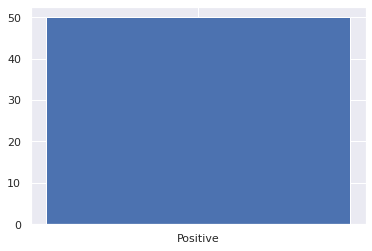

In [14]:
sentence="I like this place, the food tastes good, our waiter was very polite. but the fish is a little salty"
lm_inoculations={
    #"food" : "unknown",
}

labels_counter = cpm_debugging_predict(
    sentence,
    lm_inoculations,
    k=50
)
plt.bar(labels_counter.keys(), labels_counter.values())

### LIME Explanations for Debugging with Static Representations

Define a `predict_proba` function both for the original CPM model, and one for the "debiased" version where a static representation is swapped in.

In [15]:
def predict_proba(sentences):
    explanator.blackbox_model.eval()
    explanator.cpm_model.model.eval()
    is_split_into_words = isinstance(sentences[0], List)
    x = explanator.tokenizer(sentences, padding=True, truncation=True, return_tensors='pt',
                             is_split_into_words=is_split_into_words)
    x_batch = {k: v.to(explanator.device) for k, v in x.items()}
    outputs = explanator.cpm_model.model(
        **x_batch,
        output_hidden_states=False
    )
    output_logits = torch.nn.functional.softmax(
        outputs.logits[0].cpu(), dim=-1
    ).detach()
    return output_logits.numpy()

In [35]:
def predict_proba_debias(sentences, lm_inoculations):
    explanator.blackbox_model.eval()
    explanator.cpm_model.model.eval()
    
    is_split_into_words = isinstance(sentences[0], List)
    x = explanator.tokenizer(sentences, padding=True, truncation=True, return_tensors='pt',
                             is_split_into_words=is_split_into_words)
    x_batch = {k: v.to(explanator.device) for k, v in x.items()}
    outputs = explanator.cpm_model.model(
        **x_batch,
        output_hidden_states=True,
    )
    cls_hidden_state = outputs.hidden_states[-1][:,0,:]

    hidden_repr_static_pool = {}
    for k, v in explanator.hidden_repr_static_pool.items():
        # this is to take the mean, can we do better?
        idx = random.randrange(v.shape[0])
        vv = v[idx].to(explanator.device)
        hidden_repr_static_pool[k] = vv

    for k, v in lm_inoculations.items():
        if k == "ambiance":
            intervention_corr = 0
        if k == "food":
            intervention_corr = 1
        if k == "noise":
            intervention_corr = 2
        if k == "service":
            intervention_corr = 3
        start_idx = intervention_corr*explanator.intervention_h_dim
        end_idx = (intervention_corr+1)*explanator.intervention_h_dim
        cls_hidden_state[:, start_idx:end_idx] = hidden_repr_static_pool[(k, v)]

    intervened_outputs, _, _ = explanator.cpm_model.forward_with_cls_hidden_reprs(
        cls_hidden_reprs=cls_hidden_state.unsqueeze(dim=1)
    )

    intervened_output_logits = torch.nn.functional.softmax(
        intervened_outputs.logits[0].cpu(), dim=-1
    ).detach()
    return intervened_output_logits.numpy()

Set up LIME explainer model

In [21]:
from lime.lime_text import LimeTextExplainer

class_names = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
explainer = LimeTextExplainer(class_names=class_names)

Use LIME to explain original CPM model

In [23]:
# label chooses which classification to focus on (words are highlighted as contributing to specific classification)
exp = explainer.explain_instance(sentence, predict_proba, labels=[3], num_features=6)
exp.show_in_notebook(text=True)

Use LIME to explain CPM model that is debiased with respect to food

In [28]:
def predict_proba_debias_food(sentences):
    return predict_proba_debias(sentences, lm_inoculations={'food': 'unknown'})

exp = explainer.explain_instance(sentence, predict_proba_debias_food, labels=[3], num_features=6)
exp.show_in_notebook(text=True)

Experiment with example sentences. The example sentence below is (very) positive about the food, but negative about all other aspects. The original CPM model predicts an overall Positive sentiment for this review; however, the CPM model that is "debiased" with respect to food (aiming to neutralize its aspect) predicts an overall Negative sentiment.

/anaconda/envs/nlu/lib/python3.9/site-packages/transformers/modeling_utils.py:812: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Sentence: Even though the music was loud, the waiter was rude, and the place was crowded, the food was exceptional! Will definitely return
Inoculations: {'food': 'unknown'}
***** Original *****
Review Ratings: Positive (Confidence: 86.16%)
Ambiance Ratings: Negative (Confidence: 45.27%)
Food Ratings: Positive (Confidence: 99.67%)
Noise Ratings: Negative (Confidence: 94.44%)
Service Ratings: Negative (Confidence: 86.92%)
***** Neural Edit *****


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1251.63it/s]


<BarContainer object of 1 artists>

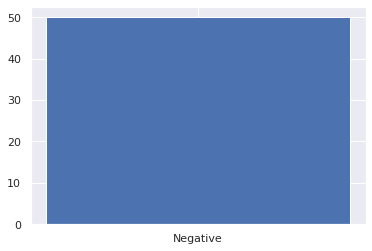

In [46]:
example_sentence = 'Even though the music was loud, the waiter was rude, and the place was crowded, the food was exceptional! Will definitely return'

lm_inoculations={
    "food" : "unknown",
}

labels_counter = cpm_debugging_predict(
    example_sentence,
    lm_inoculations,
    k=50
)
plt.bar(labels_counter.keys(), labels_counter.values())

In [47]:
exp = explainer.explain_instance(example_sentence, predict_proba, labels=[3], num_features=6)
exp.show_in_notebook(text=True)

/anaconda/envs/nlu/lib/python3.9/site-packages/transformers/modeling_utils.py:812: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [48]:
exp = explainer.explain_instance(example_sentence, predict_proba_debias_food, labels=[3], num_features=6)
exp.show_in_notebook(text=True)

/anaconda/envs/nlu/lib/python3.9/site-packages/transformers/modeling_utils.py:812: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


### Gradient-Based Explanation

Applies a simple saliency map to the specified output (or set of weights) in order to determine which parts of the text influenced the model most.

In [12]:
def tokenize_sentence(sentence):
    """
    Tokenize the sentence using the `explanator` tokenizer
    """
    explanator.blackbox_model.eval()
    explanator.cpm_model.model.eval()
    is_split_into_words = isinstance(sentence, List)
    # Original ratings.
    x = explanator.tokenizer([sentence], padding=True, truncation=True, return_tensors='pt', is_split_into_words=is_split_into_words)
    x_batch = {k: v.to(explanator.device) for k, v in x.items()}
    return x_batch

This function applies a saliency map on the gradient of one of the five logits: original review (0), ambiance sentiment (1), food sentiment (2), noise sentiment (3), and service sentiment (4). 

In [13]:
def explain_logits_with_gradients(sentence, aspect=0):
    """
    Applies a saliency map on the logits of the output of the `explanator` 
    model when run on a single input sentence. It uses the tokens produced by
    the `explanator` tokenizer to determine which parts of the input had the
    most influence on the chosen logit.

    aspect : int
        Chooses which output to focus on, from the following:
        0 - overall review
        1 - ambiance
        2 - food
        3 - noise
        4 - service
    """
    explanator.blackbox_model.eval()
    explanator.cpm_model.model.eval()

    x = tokenize_sentence(sentence)
    outputs = explanator.cpm_model.model(
        **x,
        output_hidden_states=True,
    )

    outputs.hidden_states[0].retain_grad()

    classification = outputs.logits[aspect].argmax()
    output_max = outputs.logits[aspect][0, classification]
    output_max.backward()
    saliency, _ = torch.max(outputs.hidden_states[0].grad.data.abs(), dim=-1)
    grad_df = pd.DataFrame({
    'word': explanator.tokenizer.convert_ids_to_tokens(x['input_ids'][0]),
    'weight': saliency.detach().cpu()[0]
    })

    _ = sns.barplot(data=grad_df, x='word', y='weight')
    _ = plt.xticks(rotation=90)


In [15]:
sentence="I like this place, the food tastes good, our waiter was very polite. but the fish is a little salty"

c:\Users\amirz\anaconda3\envs\nlu\lib\site-packages\transformers\modeling_utils.py:699: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


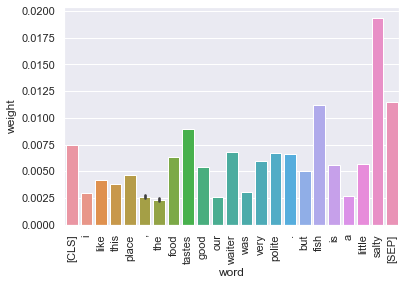

In [16]:
# which tokens had the most effect on the prediction for the overall review?
explain_logits_with_gradients(sentence)

c:\Users\amirz\anaconda3\envs\nlu\lib\site-packages\transformers\modeling_utils.py:699: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


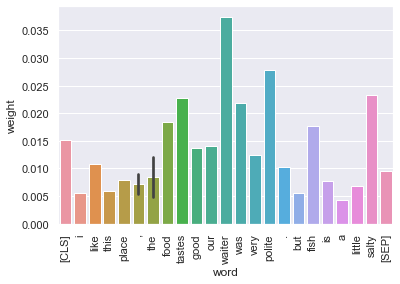

In [17]:
# which tokens had the most effect on the prediction for the service sentiment?
explain_logits_with_gradients(sentence, aspect=4)

The function below applies a similar saliency map, but this time on the particular dimensions that the CPM uses on the final layer in order to represent a particular aspect (ambiance, food, noise, or service). 

In [19]:
def explain_interventions_with_gradients(sentence, aspect):
    """
    Provides gradient-based saliency map to display which tokens 
    had the most effect on the intermediate representations
    encoded by the `explanator.cpm_model` in the final layer.

    aspect : int
        Chooses which embedded aspect to focus on.
        0 - ambiance
        1 - food
        2 - noise
        3 - service
    """
    explanator.blackbox_model.eval()
    explanator.cpm_model.model.eval()

    x = tokenize_sentence(sentence)
    outputs = explanator.cpm_model.model(
        **x,
        output_hidden_states=True,
    )

    outputs.hidden_states[0].retain_grad()

    start_idx = aspect*explanator.intervention_h_dim
    end_idx = (aspect+1)*explanator.intervention_h_dim

    argmax = outputs.hidden_states[-1][:, 0, start_idx:end_idx].argmax()
    output_max = outputs.hidden_states[-1][:, 0, start_idx:end_idx][0, argmax]

    output_max.backward()
    saliency, _ = torch.max(outputs.hidden_states[0].grad.data.abs(), dim=-1)
    grad_df = pd.DataFrame({
    'word': explanator.tokenizer.convert_ids_to_tokens(x['input_ids'][0]),
    'weight': saliency.detach().cpu()[0]
    })

    ax = sns.barplot(data=grad_df, x='word', y='weight')
    _ = plt.xticks(rotation=90)


Below are examples of the saliency map produced for each aspect, with an example sentence that comments on each aspect (or tries to).

__Note: This doesn't look as great as I'd hoped -- any ideas or suggestions would be appreciated!!__

In [20]:
example_sentence = 'Despite the loud music, rude waiter, and tasteless decorations, I will 100 percent return to this place for the incredible pasta'

c:\Users\amirz\anaconda3\envs\nlu\lib\site-packages\transformers\modeling_utils.py:699: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


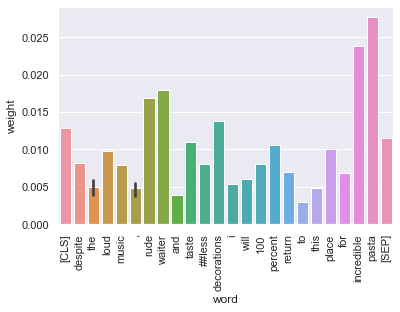

In [21]:
# which tokens influence the representation of ambiance?
explain_interventions_with_gradients(example_sentence, 0)

c:\Users\amirz\anaconda3\envs\nlu\lib\site-packages\transformers\modeling_utils.py:699: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


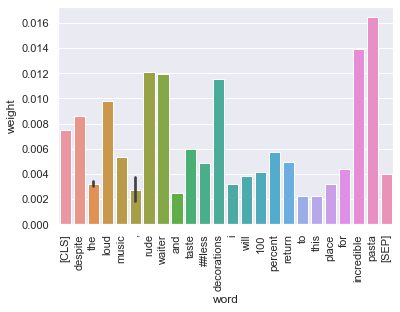

In [22]:
# which tokens influence the representation of food?
explain_interventions_with_gradients(example_sentence, 1)

c:\Users\amirz\anaconda3\envs\nlu\lib\site-packages\transformers\modeling_utils.py:699: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


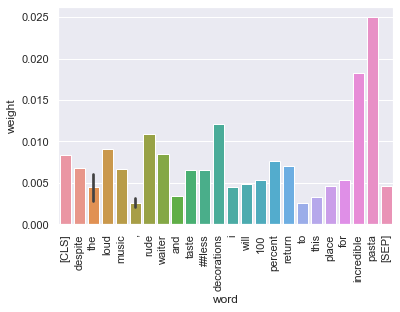

In [23]:
# which tokens influence the representation of noise?
explain_interventions_with_gradients(example_sentence, 2)

c:\Users\amirz\anaconda3\envs\nlu\lib\site-packages\transformers\modeling_utils.py:699: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


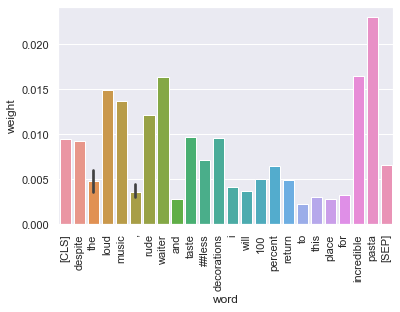

In [24]:
# which tokens influence the representation of service?
explain_interventions_with_gradients(example_sentence, 3)